In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
MOVIE_DIR="./images"

CREATE_MOVIE = False # True if you have ffmpeg installed

import training_models_helper
%aimport training_models_helper

tmh = training_models_helper.TrainingModelsHelper()

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper(random_seed=42)

import recipe_helper
%aimport recipe_helper
rh = recipe_helper.Recipe_Helper()

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Becoming a successful Data Scientist: Error Analysis

As of now, you should know
- how to construct models (the "recipe")
- how to use them for prediction
- some simple metrics on how they perform

In this module, the topics to be covered provide answers:
- model diagnostics 

In other words: the importance of Error Aanalysis in diagnosing and improving models.

# Classification: Beyond accuracy

Let's re-run the MNIST problem and examine measures of error more detailed than accuracy


In [15]:
mnh = mnist_helper.MNIST_Helper(random_seed=42)
mnh.setup()
_= mnh.fit()

Retrieving MNIST_784 from cache


Examine the score (n.b., ran with L2 penalty)

In [6]:
clf = mnh.clf

 # Cross validation
scores = cross_val_score(clf, mnh.X_train, mnh.y_train, cv=10)
print("Avg cross val score={s:3.2f}\n".format( s=scores.mean()) )

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Avg cross val score=0.88

Sparsity with l2 penalty: 16.07.


We achieved an out of sample accuracy of about 87%

That sounds good, but is it really ?

If each of the 10 labels occurs with equal frequency among the training examples
- We could mis-predict *every* occurrence of a single digit (i.e., 10% of the training examples)
- And still achieve an Accuracy of 90% if we perfectly predict all other digits

Would that be satisfactory ?

This motivates the need to measure *Conditional Performance* or *Conditional Loss*
- Performance/Loss conditioned on meaningful subsets of training examples

We will examine some conditional metrics for the Classification task.

<img src="images/Back_to_parent.jpg">

# Binary classification: Conditional accuracy

To review:

For a Binary Classification task, we can partition the examples into a two dimensions
- Row labels: the *predicted* class
- Column labels: the *true* class

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

The correct predictions
- True Positives (TP) are   examples predicted as Positive that were in fact Positive
- True Positives (TN) are   examples predicted as Negative that were in fact Negative

The incorrect predictions
- False Positives (FP) are  examples predicted as Positive that were in fact Negative
- False Positives (FN) are  examples predicted as Negative that were in fact Positive


Unconditional Accuracy can thus be written as

$$\textrm{Accuracy} =  { \text{TP} + \text{TN} \over  \text{TP} + \text{FP} + \text{TN} + \text{FN} } $$

We can also define some conditional Accuracy measures

## Imbalanced data: the case for conditional accuracy

It is quite possible that the number of Positive and Negative examples in a dataset are quite different
- Titanic example: many fewer examples with `Survived` than `Not Survived`

When this occurs, unconditional measures are highly influenced by success on the dominant category
- Titanic example: The Negative examples are almost twice as numerous as the Positive
$$\text{TP} + \text{FN} << \text{TN} + \text{FP}$$

Conditional metrics are one way of placing focus on success in the minority category.

##  Recall

Conditioned on Positive examples.

$$
\textrm{Recall} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FN} }  }
$$
- The fraction of Positive examples that were correctly classified
- Also goes by the names: True Positive Rate (TPR), Sensitivity

Degenerate case:
- You can achieve 100% Recall by always predicting Positive
- But Unconditional Accuracy will suffer.

## Specificity
Conditioned on Negative examples

$$
\textrm{Specificity} = { { \textrm{TN} } \over { \textrm{TN} +  \textrm{FP} }  }
$$

- The fraction of Negative examples that were correctly classified
- Also goes by the name: True Negative Rate (TNR)

## Precision
A metric to tell you the fraction of your Positive predictions that were correct.

$$
\textrm{Precision} = { { \textrm{TP} } \over { \textrm{TP} +  \textrm{FP} }  }
$$

Degenerate case:
- You can achieve 100% Precision: Predict Positive for only a *single example* that is actually Positive 
- But you fail to correctly predict all other Positive examples

## False Positive Rate (FPR)

The fraction of Negative examples misclassified as Positive.

$$
\begin{array}{lll}
\textrm{FPR} & = & { { \textrm{FP} } \over { \textrm{FP} + \textrm{TN} } } \\
             & = & 1 - \textrm{Specificity}
\end{array}
$$

<img src="images/Back_to_parent.jpg">

## Precison/Recall Tradeoff

Ideally, we would like our model to have both
- High Recall: correctly identify a large fraction of Positive examples
- High Precision: do not mis-identify too many Negative examples as positive

But it may not be possible to have both.

We will 
- Show how to trade off one measure for the other
- Discuss when to favor one type of error over another


Some Classification models (e.g., Logistic Regression)
- Use hyperparamters (e.g., threshold)
- To convert a numerical "score" to a Categorical predicted value

By varying the threshold, we can change predictions to favor a particular Conditional Performance metric.

We will show how this happens and demonstrate ways to evaluate the tradeoff between metrics.

Recall our methodology for Classification via Logistic Regression:
- Compute a numerical "score" for our example based on its features
$$\hat{s}^\ip = \Theta \cdot \x^\ip$$

- Construct a probability distribution (over the target classes) from the scores
$$\hat{p}^\ip = \sigma(\hat{s}^\ip)  $$

- Predict by comparing the probability to a threshhold


$$
\hat{\y}^\ip = 
\left\{
    {
    \begin{array}{lll}
    0 & \textrm{if } \hat{p}^\ip < 0.5   & \text{Negative} \\
    1 & \textrm{if } \hat{p}^\ip \ge 0.5  & \text{Positive} \\
    \end{array}
    }
\right.
$$

We can visualize the step of converting probabilities to predicted class
by  plotting lines (hyper-planes) of constant score/probability

For a given constant value of score or probability:
- Examples above the line are classified as Positive
- Examples below the line are classified as Negative

We can choose **any score/probability** as our decision boundary for prediction.

Let's see what happens as we vary the boundary.

<table>
    <tr>
        <center><strong>Separation bounday as function of probability threshold</strong>/center>
    </tr>
<img src="images/class_overview_prob_lines.jpg" width=1000>
</table>


- By choosing the boundary $$\Theta^T \x = -1 \,\,\, (\text{resp., prob} = 0.27)$$
- Rather than the boundary $$\Theta^T \x =  0 \,\,\, (\text{resp., prob} = 0.50)$$

we potentially **increase** the number of examples classified as Positive
- Increasing the number of TP $\leadsto$ Increasing Recall
- But also potentially increasing the number of FP $\leadsto$ Decreasing Precision

Thus, by varying threshold, we can choose the **tradeoff between Recall and Precision**.


**Precision vs Recall: which one to favor ?**

What factors might lead us to favor one metric over the other ?

Consider a diagnostic test whose goal is to classify highly infectious patients as Positive
- High Recall: catch most infected patients
- Low Precision: frighten patients that are misclassified as Positive

You might favor Recall
- When a False Negative has very bad consequences (e.g., lead to an increase in infections in population)

You might favor Precision
- When a False Positive has very bad consequences (e.g., cause a non-infected patient to isolate)

Moving the boundary to increase Positives will naturally decrease Negative predictions.

So we also affect metrics conditioned on Negative (FN, TN), with similar tradeoffs.


### Precision/Recall tradeoff: plot

To be concrete: let's examine the tradeoff between Recall and Precision
in the context of a binary classifier
- Using MNIST examples: classify an example as being a **single** chosen digit versus the 9 other digits

- Create a binary classifier for a single MNIST digit

In [7]:
# Fetch the MNIST data into object

mnh_d = mnist_helper.MNIST_Helper(random_seed=42)
mnh_d.setup()

# Turn the 10 class training set into a binary training set
# - Same examples, different targets
# - targets are now "is 'digit'" or "is not 'digit'" for a single digit
digit = '5'
y_train_d, y_test_d = mnh_d.make_binary(digit)

# Fit a binary model: Is digit/Is not digit
mnh_d.fit(y_train=y_train_d)
scores = cross_val_score(mnh_d.clf, mnh_d.X_train, y_train_d, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnh_d.clf, mnh_d.X_train, y_train_d, cv=5, method="decision_function")


Retrieving MNIST_784 from cache


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

Let's plot the tradeoff

In [8]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_d, y_train_pred)

# Convert thresholds (log odds) to probability
probs = np.exp(thresholds)/(1+np.exp(thresholds))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=None):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    
    if probs is None:
        horiz = thresholds
        label = "Threshold"
    else:
        horiz = probs
        label = "Probability threshold"
    _ = ax.plot(horiz, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(horiz, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel(label, fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    
    _ = ax.set_xlim([ horiz.min(), horiz.max()])
    
    return fig, ax

fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=probs)
plt.close(fig)

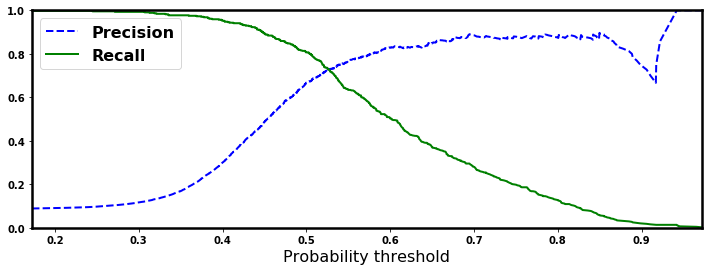

In [9]:
fig

You can see how varying the threshold  affects Recall and Precision
- One at the expense of the other

### ROC/AUC: Evaluating the Precision/Recall tradeoff

There is another common tool used to evaluate the tradeoff between competing metrics.

The **ROC** is a plot of True Positive Rate (TPR) versus the False Positive Rate (FPR) 
as we vary the threshold.

Our goal is to choose a threshold (corresponding to a point on the curve)
- With the highest True Positive Rate (TPR): fraction of correctly classified Positives
- With the smallest *acceptable* False Positive Rate (FPR): fraction of negatives that are misclassified as Positve


We illustrate by showing the ROC/AUC curve for three different classifiers on the MNIST digit recognition problem.
 
- Logistic Regression
- KNN
- Random Forests

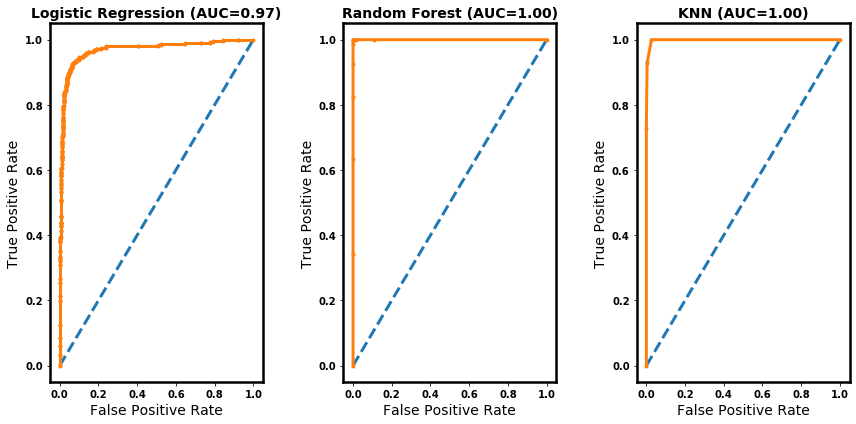

In [10]:
# ROC curves for binary classifier: Is Digit/Is not Digit
clh.AUC_plot(X_train=mnh.X_train, y_train=y_train_d, X_test=mnh.X_train, y_test=y_train_d)


The "ideal" curve would resemble an inverted "L"
- With a top, horizontal line near a TPR of $1$
- That rises vertically from a FPR of near $0$

That would imply that there is a choice of threshold with low FPR and high TPR.

**You** decide which threshold produces an acceptable tradeoff

But you can also compare the curves across models
- A model whose curve is closer to the inverted "L" shape has a better tradeoff
- We can measure this by the *Area Under the Curve* (AUC) of the model
    - Higher AUC gets us closer to the ideal
- The model whose curve has highest AUC might be the model of choice.

**Note on the mechanics of plotting the ROC/AUC**

To produce the ROC/AUC curve
- Fit a binary classifier
- For each possible value of the threshold
    - Predict using this threshold
    - Evaluate the TPR and FPR
    - This gives a single point on the curve

Fortunately: most ML toolkits will implement this process for you
- But the principle of "there is no magic" means that you should always understand what is happening

### $F_1$: Another way to combine Precision and Recall

There another metric call the $F_1$ which expresses the tradeoff between Precision and Recall as a single number:

$$
\textrm{F}_1 = { { \textrm{TP} } \over { \textrm{TP} +  { { \textrm{FN} + \textrm{FP} }   \over 2 } }  }
$$

<img src="images/Back_to_parent.jpg">

# Multinomial classification: Confusion matrix

So far we have been dealing with a classifier with only two classes.

So the simple grid

$$
\begin{array}{lll}
\\
           & \textbf{P} &  \textbf{N} \\
\textbf{P} & \text{TP}        & \text{FP} \\
\textbf{N} & \text{FN}        & \text{TN} \\
\end{array}
$$

was sufficient.

The generalization of the grid to  multiple classes is called the *Confusion Matrix*

Here is the Confusion Matrix for a classifier on the task of predicting which of 10 digits
is represented by an image (MNIST digit recognition)

Normalized confusion matrix


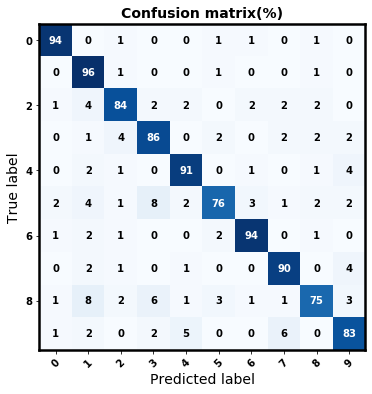

In [18]:
# Now predict the value of the digit on the second half:
fig, ax = plt.subplots(figsize=(12,6))
confusion_mat = mnh.create_confusion_matrix()

digits = range(0,10)
_= clh.plot_confusion_matrix(confusion_mat, digits, ax=ax, normalize=True)

- Column labels: the *predicted* class
- Row labels: the *true* class

The entry in the matrix for row $i$, column $j$
- **Percentage** of examples for true digit $i$ that were
predicted as digit $j$.

The diagonal of the Confusion Matrix is the Recall for each digit/

The non-diagonal elements of a row show how often a given digit was mistaken for another.


The confusion matrix for MNIST digit recognition tells us that our classifier
- Does a great job (97% correct) on images corresponding to digits 0,1
- Is struggling ($ < 80 \%$ correct) on images of the digits 5, 8
    - Mis-classifying them as "3" most often


Studying the Confusion Matrix in depth can help you
- Diagnose the weaknesses in your model
- And *perhaps take steps to compensate* for them (improve the model)
- By analyzing the examples belonging to the subset corresponding to non-diagonal entries

**This is the true power of Error Analysis !**
- Having a process and the tools to diagnose mis-prediction will make you more successful !
- That is why we emphasize the importance of the Error Analysis step of the Recipe

We will perform this analysis *in code*  for the MNIST digit classifier shortly.

<img src="images/Back_to_parent.jpg">

## Regression: beyond RMSE/$R^2$

What is the process of diagnosing errors for the Regression task ?

Answer: Examining the residuals.

We illustrate that by examining the errors for one of our first models
- Using Linear Regression with the single, raw feature (Size) to fit the "curvy" dataset of Price Premium

Coefficients: 
 [9.86448852] [[0.93673892]]


R-squared (test): 0.91
Root Mean squared error (test): 13.73


R-squared (train): 0.91
Root Mean squared error (train): 13.13


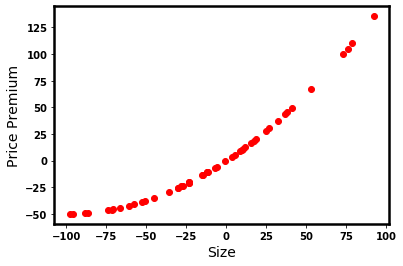

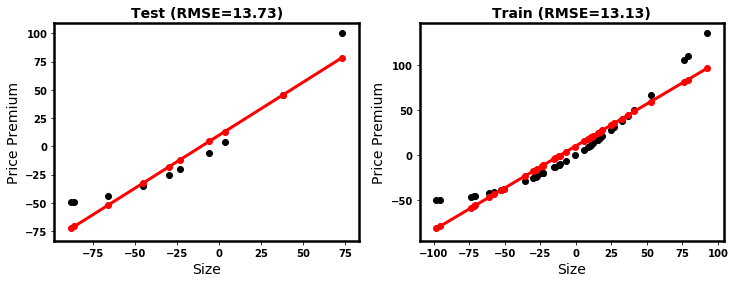

In [12]:
v1, a1 = 1, .005
v2, a2 = v1, a1*2
curv = recipe_helper.Recipe_Helper(v = v2, a = a2)
X_curve, y_curve = curv.gen_data(num=50)

(xlabel, ylabel) = ("Size", "Price Premium")

figp, axp = curv.gen_plot(X_curve,y_curve, xlabel, ylabel)

fig, axs = curv.regress_with_error(X_curve, y_curve, xlabel=xlabel, ylabel=ylabel)
plt.close(fig)

Let's focus on the Test errors (which are the *residuals*: difference between predicted and true targets)

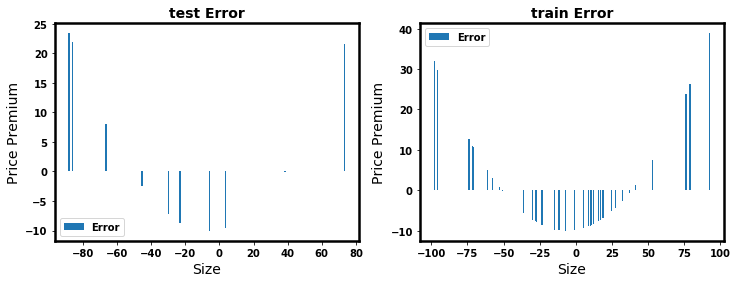

In [13]:
fig

Not good !
- There is a clear pattern to the errors:
    - Positive mis-prediction for extreme values of the single feature (Size)
    - Negative mis-prediction for central values of the single feature
- Non-constant variance
    - Absolute value of the errors at the extremes are larger

Let's consider the business implication of this pattern
- We *overprice* extremely large and extremely small homes
- We *underprice* homes of a more common size

This systematic mispricing may drive away customers !

A new feature (Size squared) 
- Is large for extreme values of the Size feature
- Is small for central values of the feature

That is: it has the same pattern as the residuals of the single-feature model.

So adding it as a new synthetic feature "predicts" the residuals and thus result in
a two-feature model with *smaller* residuals

Once we added that term, we saw that the target was fit well by the model
$$ \hat{\y} = \beta_0 +  \beta_1 *\x + \beta_2 * \x^2$$

In [14]:
print("Done")

Done
